In [1]:
%load_ext autoreload

In [2]:
%autoreload 
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import utilities as ut
from pvlib import solarposition
# from dataprep.eda import create_report

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
from featurewiz import FeatureWiz

Imported 0.3.2 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False, skip_xgboost=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



# Import the processed data

In [4]:
data_path = 'training_data/processed/'
save_path = 'training_data/hourly_mean/'

In [5]:
df = pd.read_csv(f'{data_path}df.csv')
df = df.set_index('date_forecast')
df.index = pd.to_datetime(df.index)

FileNotFoundError: [Errno 2] No such file or directory: 'training_data/processed/df.csv'

In [ ]:
X_test = pd.read_csv(f'{data_path}X_test.csv')
X_test = X_test.set_index('date_forecast')
X_test.index = pd.to_datetime(X_test.index)
X_test.date_calc = pd.to_datetime(X_test.date_calc)


In [ ]:
# move 'elevation:m', 'building', 'pv_measurement' to the end of the dataframe
df = df[[c for c in df if c not in ['elevation:m', 'building', 'pv_measurement']] 
       + ['elevation:m', 'building', 'pv_measurement']]

X_test = X_test[[c for c in X_test if c not in ['elevation:m', 'building']]
                     + ['elevation:m', 'building']]

### Add datetime features

In [ ]:
# add datetime64 features to the dataframes such as hour, day, month, year, minute (not in utilities)
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_of_week
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['day_of_year'] = df.index.dayofyear
df['day'] = df.index.day
df['minute'] = df.index.minute

X_test['hour'] = X_test.index.hour
X_test['day_of_week'] = X_test.index.day_of_week
X_test['quarter'] = X_test.index.quarter
X_test['month'] = X_test.index.month
X_test['year'] = X_test.index.year
X_test['day_of_year'] = X_test.index.dayofyear
X_test['day'] = X_test.index.day
X_test['minute'] = X_test.index.minute

#### Adding some new features:

Trying some intuitive features

In [ ]:
# Derived Features
df['temp_dewpoint_diff'] = df['dew_point_2m:K'] - df['t_1000hPa:K']
df['solar_radiation_ratio'] = df['direct_rad:W'] / df['clear_sky_rad:W']

# Weather-related Features
df['wind_speed_magnitude'] = (df['wind_speed_u_10m:ms']**2 + df['wind_speed_v_10m:ms']**2 + df['wind_speed_w_1000hPa:ms']**2)**0.5
df['cumulative_precipitation'] = df['precip_5min:mm'].rolling(window=12).sum()  # Sum over the past 1 hour (5*12 = 60 minutes)

# Interaction Features
df['temp_solar_interaction'] = df['t_1000hPa:K'] * df['direct_rad:W']

In [ ]:
# Derived Features
X_test['temp_dewpoint_diff'] = X_test['dew_point_2m:K'] - X_test['t_1000hPa:K']
X_test['solar_radiation_ratio'] = X_test['direct_rad:W'] / X_test['clear_sky_rad:W']

# Weather-related Features
X_test['wind_speed_magnitude'] = (X_test['wind_speed_u_10m:ms']**2 + X_test['wind_speed_v_10m:ms']**2 + X_test['wind_speed_w_1000hPa:ms']**2)**0.5
X_test['cumulative_precipitation'] = X_test['precip_5min:mm'].rolling(window=12).sum()  # Sum over the past 1 hour (5*12 = 60 minutes)

# Interaction Features
X_test['temp_solar_interaction'] = X_test['t_1000hPa:K'] * X_test['direct_rad:W']

Trying some pv related features generated using a solar power library. NB assuming the buildings are located in Trondheim

In [ ]:
# Function to add solar-related features using pvlib
def add_solar_features_pvlib(df):
    # Fixed latitude and longitude
    latitude = 63.430515
    longitude = 10.395053

    times = pd.to_datetime(df[['year','month', 'day', 'hour', 'minute']])
    altitudes = df['elevation:m']
    temperatures = df['t_1000hPa:K'] - 273.15
    
    # Calculate solar positions
    solar_position = solarposition.get_solarposition(times, latitude, longitude, altitudes, temperature=temperatures)

    # Add solar position features to the dataframe
    df['sun_zenith:d'] = solar_position['apparent_zenith']
    df['sun_equation_of_time'] = solar_position['equation_of_time']

    return df

In [ ]:
df = add_solar_features_pvlib(df)
X_test = add_solar_features_pvlib(X_test)

In [ ]:
df.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,day_of_year,day,minute,temp_dewpoint_diff,solar_radiation_ratio,wind_speed_magnitude,cumulative_precipitation,temp_solar_interaction,sun_zenith:d,sun_equation_of_time
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.6,1.239,1226.4,0.0,0.0,1226.4,0.0,275.4,0.0,0.0,...,1,1,0,-3.0,NaN,2.459675,NaN,0.0,139.103522,-3.195874
2019-01-01 00:15:00,5.6,1.239,1209.3,0.0,0.0,1209.3,0.0,275.2,0.0,0.0,...,1,1,15,-3.1,NaN,2.683282,NaN,0.0,138.636359,-3.200828
2019-01-01 00:30:00,5.5,1.240,1192.1,0.0,0.0,1192.1,0.0,275.1,0.0,0.0,...,1,1,30,-3.1,NaN,2.954657,NaN,0.0,138.026446,-3.205782
2019-01-01 00:45:00,5.4,1.241,1174.9,0.0,0.0,1174.9,0.0,274.9,0.0,0.0,...,1,1,45,-3.2,NaN,3.138471,NaN,0.0,137.281281,-3.210734
2019-01-01 01:00:00,5.4,1.241,1157.6,0.0,0.0,1157.6,0.0,274.7,0.0,0.0,...,1,1,0,-3.3,NaN,3.361547,NaN,0.0,136.409500,-3.215687


In [ ]:
X_test.head()

,date_calc,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,day_of_year,day,minute,temp_dewpoint_diff,solar_radiation_ratio,wind_speed_magnitude,cumulative_precipitation,temp_solar_interaction,sun_zenith:d,sun_equation_of_time
date_forecast,,,,,,,,,,,,,,,,,,,,,
2023-05-01 00:00:00,2023-04-30 07:00:04,4.3,1.283,912.3,0.0,0.0,1039.9,0.0,271.7,0.0,...,121,1,0,-2.1,NaN,4.049691,NaN,0.0,101.166019,2.806174
2023-05-01 00:15:00,2023-04-30 07:00:04,4.3,1.283,912.3,0.0,0.0,1053.1,0.0,271.7,0.0,...,121,1,15,-2.1,NaN,3.996248,NaN,0.0,100.792356,2.807480
2023-05-01 00:30:00,2023-04-30 07:00:04,4.3,1.283,912.3,0.0,0.0,1066.4,0.0,271.6,0.0,...,121,1,30,-2.2,NaN,3.996248,NaN,0.0,100.314960,2.808785
2023-05-01 00:45:00,2023-04-30 07:00:04,4.3,1.283,912.3,0.0,0.0,1079.6,0.0,271.6,0.0,...,121,1,45,-2.2,NaN,3.858756,NaN,0.0,99.736307,2.810090
2023-05-01 01:00:00,2023-04-30 07:00:04,4.3,1.283,NaN,0.0,0.0,1092.9,0.0,271.6,0.0,...,121,1,0,-2.2,NaN,3.858756,NaN,0.0,99.059338,2.811393


In [ ]:
# check for missing values
df.isnull().sum()

absolute_humidity_2m:gm3               0
air_density_2m:kgm3                    0
ceiling_height_agl:m               46980
clear_sky_energy_1h:J                  0
clear_sky_rad:W                        0
cloud_base_agl:m                   20752
dew_or_rime:idx                        0
dew_point_2m:K                         0
diffuse_rad:W                          0
diffuse_rad_1h:J                       0
direct_rad:W                           0
direct_rad_1h:J                        0
effective_cloud_cover:p                0
fresh_snow_12h:cm                      0
fresh_snow_1h:cm                       0
fresh_snow_24h:cm                      0
fresh_snow_3h:cm                       0
fresh_snow_6h:cm                       0
is_day:idx                             0
is_in_shadow:idx                       0
msl_pressure:hPa                       0
precip_5min:mm                         0
precip_type_5min:idx                   0
pressure_100m:hPa                      0
pressure_50m:hPa

In [ ]:
X_test.isnull().sum()

date_calc                            0
absolute_humidity_2m:gm3             0
air_density_2m:kgm3                  0
ceiling_height_agl:m              1604
clear_sky_energy_1h:J                0
clear_sky_rad:W                      0
cloud_base_agl:m                   652
dew_or_rime:idx                      0
dew_point_2m:K                       0
diffuse_rad:W                        0
diffuse_rad_1h:J                     0
direct_rad:W                         0
direct_rad_1h:J                      0
effective_cloud_cover:p              0
fresh_snow_12h:cm                    0
fresh_snow_1h:cm                     0
fresh_snow_24h:cm                    0
fresh_snow_3h:cm                     0
fresh_snow_6h:cm                     0
is_day:idx                           0
is_in_shadow:idx                     0
msl_pressure:hPa                     0
precip_5min:mm                       0
precip_type_5min:idx                 0
pressure_100m:hPa                    0
pressure_50m:hPa         

#### We have weather features for each quarter but only pv_measurment for each hour, we want to create a new dataframe where we use the average feature data for each pv_measurement

In [ ]:
# start with making two new temporary dataframes temp_B and temp_C which contain df sorted by building
df_temp_A = df[df['building'] == 0]
df_temp_B = df[df['building'] == 1]
df_temp_C = df[df['building'] == 2]


# cerate a new temporary dataframe by removing pv_measurement from df
df_temp_A = df_temp_A.drop(columns=['pv_measurement', 'building', 'elevation:m'])
df_temp_B = df_temp_B.drop(columns=['pv_measurement', 'building', 'elevation:m'])
df_temp_C = df_temp_C.drop(columns=['pv_measurement', 'building', 'elevation:m'])

# for each whole hour, replace the features with the mean of the previous 12 hours
df_temp_A = df_temp_A.resample('H').mean().ffill().bfill()
df_temp_B = df_temp_B.resample('H').mean().ffill().bfill()
df_temp_C = df_temp_C.resample('H').mean().ffill().bfill()


# add the pv_measurement column back to the dataframes
df_temp_A['pv_measurement'] = df[df['building'] == 0]['pv_measurement']
df_temp_B['pv_measurement'] = df[df['building'] == 1]['pv_measurement']
df_temp_C['pv_measurement'] = df[df['building'] == 2]['pv_measurement']

# add the building column back to the dataframes
df_temp_A['building'] = df[df['building'] == 0]['building']
df_temp_B['building'] = df[df['building'] == 1]['building']
df_temp_C['building'] = df[df['building'] == 2]['building']


# overwrite df as df_temp_B and df_temp_C stacked on top of each other
df = pd.concat([df_tempA,df_temp_B, df_temp_C])

In [ ]:
df

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,minute,temp_dewpoint_diff,solar_radiation_ratio,wind_speed_magnitude,cumulative_precipitation,temp_solar_interaction,sun_zenith:d,sun_equation_of_time,pv_measurement,building
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.525,1.23975,1200.675,0.00,0.000,1200.675,0.0,275.150,0.000,0.00,...,22.5,-3.100,0.0,2.809021,2.000000e-01,0.0,138.261902,-3.203305,0.00,1.0
2019-01-01 01:00:00,5.425,1.23975,1131.425,0.00,0.000,1131.425,0.0,274.825,0.000,0.00,...,22.5,-3.250,0.0,3.547774,2.000000e-01,0.0,134.821300,-3.223114,0.00,1.0
2019-01-01 02:00:00,5.400,1.23850,1061.000,0.00,0.000,1061.000,0.0,274.800,0.000,0.00,...,22.5,-3.250,0.0,4.044272,2.000000e-01,0.0,129.748348,-3.242916,0.00,1.0
2019-01-01 03:00:00,5.350,1.23975,1021.150,0.00,0.000,1021.150,0.0,274.675,0.000,0.00,...,22.5,-2.925,0.0,4.935922,2.150000e-01,0.0,123.653918,-3.262709,0.00,1.0
2019-01-01 04:00:00,5.675,1.23750,1033.700,0.00,0.000,1033.700,0.0,275.500,0.000,0.00,...,22.5,-2.150,0.0,6.057831,2.400000e-01,0.0,117.063598,-3.282494,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 19:00:00,4.400,1.27550,1456.575,84010.15,4.175,551.225,0.0,272.025,2.775,54774.00,...,22.5,-2.900,0.0,4.061255,-1.110223e-16,0.0,89.519936,2.781838,50.96,2.0
2023-04-30 20:00:00,4.400,1.27850,1476.350,2206.80,0.000,564.100,0.0,271.950,0.000,4984.05,...,22.5,-2.625,0.0,3.640372,-1.110223e-16,0.0,94.824522,2.787127,2.94,2.0
2023-04-30 21:00:00,4.400,1.27900,1516.300,0.00,0.000,578.700,0.0,271.900,0.000,0.00,...,22.5,-2.500,0.0,3.556890,-1.110223e-16,0.0,98.609479,2.792401,0.00,2.0


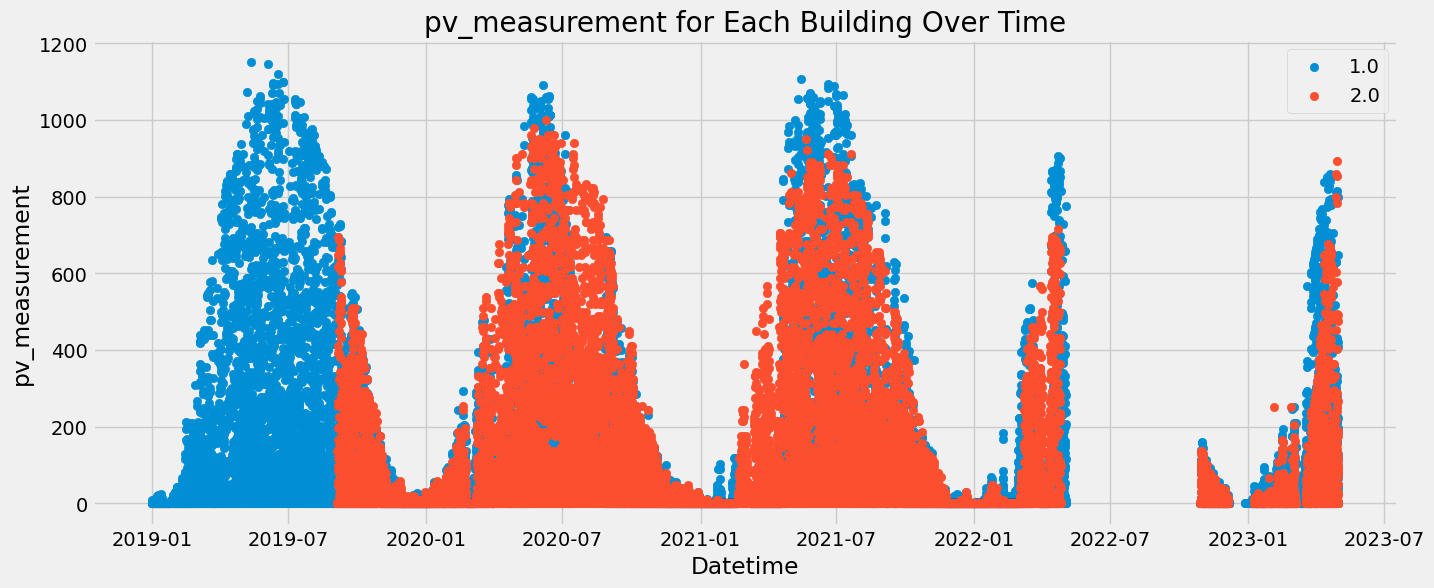

In [ ]:
plt.figure(figsize=(15, 6))

for building, data in df.groupby('building'):
    plt.scatter(data.index, data['pv_measurement'], label=building, marker='o')

plt.xlabel('Datetime')
plt.ylabel('pv_measurement')
plt.title('pv_measurement for Each Building Over Time')
plt.legend()
plt.show()

### Seems like it worked :o

In [ ]:
df.isnull().sum()

absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
ceiling_height_agl:m                  0
clear_sky_energy_1h:J                 0
clear_sky_rad:W                       0
cloud_base_agl:m                      0
dew_or_rime:idx                       0
dew_point_2m:K                        0
diffuse_rad:W                         0
diffuse_rad_1h:J                      0
direct_rad:W                          0
direct_rad_1h:J                       0
effective_cloud_cover:p               0
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                            0
is_in_shadow:idx                      0
msl_pressure:hPa                      0
precip_5min:mm                        0
precip_type_5min:idx                  0
pressure_100m:hPa                     0
pressure_50m:hPa                      0


In [ ]:
# remove all rows where pv_measurement is NaN
df = df.dropna(subset=['pv_measurement'])
df.isnull().sum()

absolute_humidity_2m:gm3          0
air_density_2m:kgm3               0
ceiling_height_agl:m              0
clear_sky_energy_1h:J             0
clear_sky_rad:W                   0
cloud_base_agl:m                  0
dew_or_rime:idx                   0
dew_point_2m:K                    0
diffuse_rad:W                     0
diffuse_rad_1h:J                  0
direct_rad:W                      0
direct_rad_1h:J                   0
effective_cloud_cover:p           0
fresh_snow_12h:cm                 0
fresh_snow_1h:cm                  0
fresh_snow_24h:cm                 0
fresh_snow_3h:cm                  0
fresh_snow_6h:cm                  0
is_day:idx                        0
is_in_shadow:idx                  0
msl_pressure:hPa                  0
precip_5min:mm                    0
precip_type_5min:idx              0
pressure_100m:hPa                 0
pressure_50m:hPa                  0
prob_rime:p                       0
rain_water:kgm2                   0
relative_humidity_1000hPa:p 

#### Automativ featued analysis and selection using FeatureWiz

In [ ]:
FEATURES = list(df.columns)

FEATURES.remove('pv_measurement')

TARGET = 'pv_measurement'

X_train = df[FEATURES]
y_train = df[TARGET]

X_test = X_test[FEATURES]

In [ ]:
FEATURES

['absolute_humidity_2m:gm3',
 'air_density_2m:kgm3',
 'ceiling_height_agl:m',
 'clear_sky_energy_1h:J',
 'clear_sky_rad:W',
 'cloud_base_agl:m',
 'dew_or_rime:idx',
 'dew_point_2m:K',
 'diffuse_rad:W',
 'diffuse_rad_1h:J',
 'direct_rad:W',
 'direct_rad_1h:J',
 'effective_cloud_cover:p',
 'fresh_snow_12h:cm',
 'fresh_snow_1h:cm',
 'fresh_snow_24h:cm',
 'fresh_snow_3h:cm',
 'fresh_snow_6h:cm',
 'is_day:idx',
 'is_in_shadow:idx',
 'msl_pressure:hPa',
 'precip_5min:mm',
 'precip_type_5min:idx',
 'pressure_100m:hPa',
 'pressure_50m:hPa',
 'prob_rime:p',
 'rain_water:kgm2',
 'relative_humidity_1000hPa:p',
 'sfc_pressure:hPa',
 'snow_water:kgm2',
 'sun_azimuth:d',
 'sun_elevation:d',
 'super_cooled_liquid_water:kgm2',
 't_1000hPa:K',
 'total_cloud_cover:p',
 'visibility:m',
 'wind_speed_10m:ms',
 'wind_speed_u_10m:ms',
 'wind_speed_v_10m:ms',
 'wind_speed_w_1000hPa:ms',
 'hour',
 'day_of_week',
 'quarter',
 'month',
 'year',
 'day_of_year',
 'day',
 'minute',
 'temp_dewpoint_diff',
 'solar_ra

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (58890, 57)
    Some column names had special characters which were removed...
#### Single_Label Re

        2 variable(s) to be removed since ID or low-information variables
    	variables removed = ['minute', 'building']
train data shape before dropping 2 columns = (58890, 57)
	train data shape after dropping columns = (58890, 55)
No GPU active on this device
    Tuning XGBoost using CPU hyper-parameters. This will take time...
Removing 2 columns from further processing since ID or low information variables
    After removing redundant variables from further processing, features left = 54
No interactions created for categorical vars since feature engg does not specify it
#######################################################################################
#####  Searching for Uncorrelated List Of Variables (SULOV) in 54 features ############
#######################################################################################
    there are no null values in dataset...
    Removing (16) highly correlated variables:
    ['clear_sky_energy_1hJ', 'dew_point_2mK', 'diffuse_radW', 'di

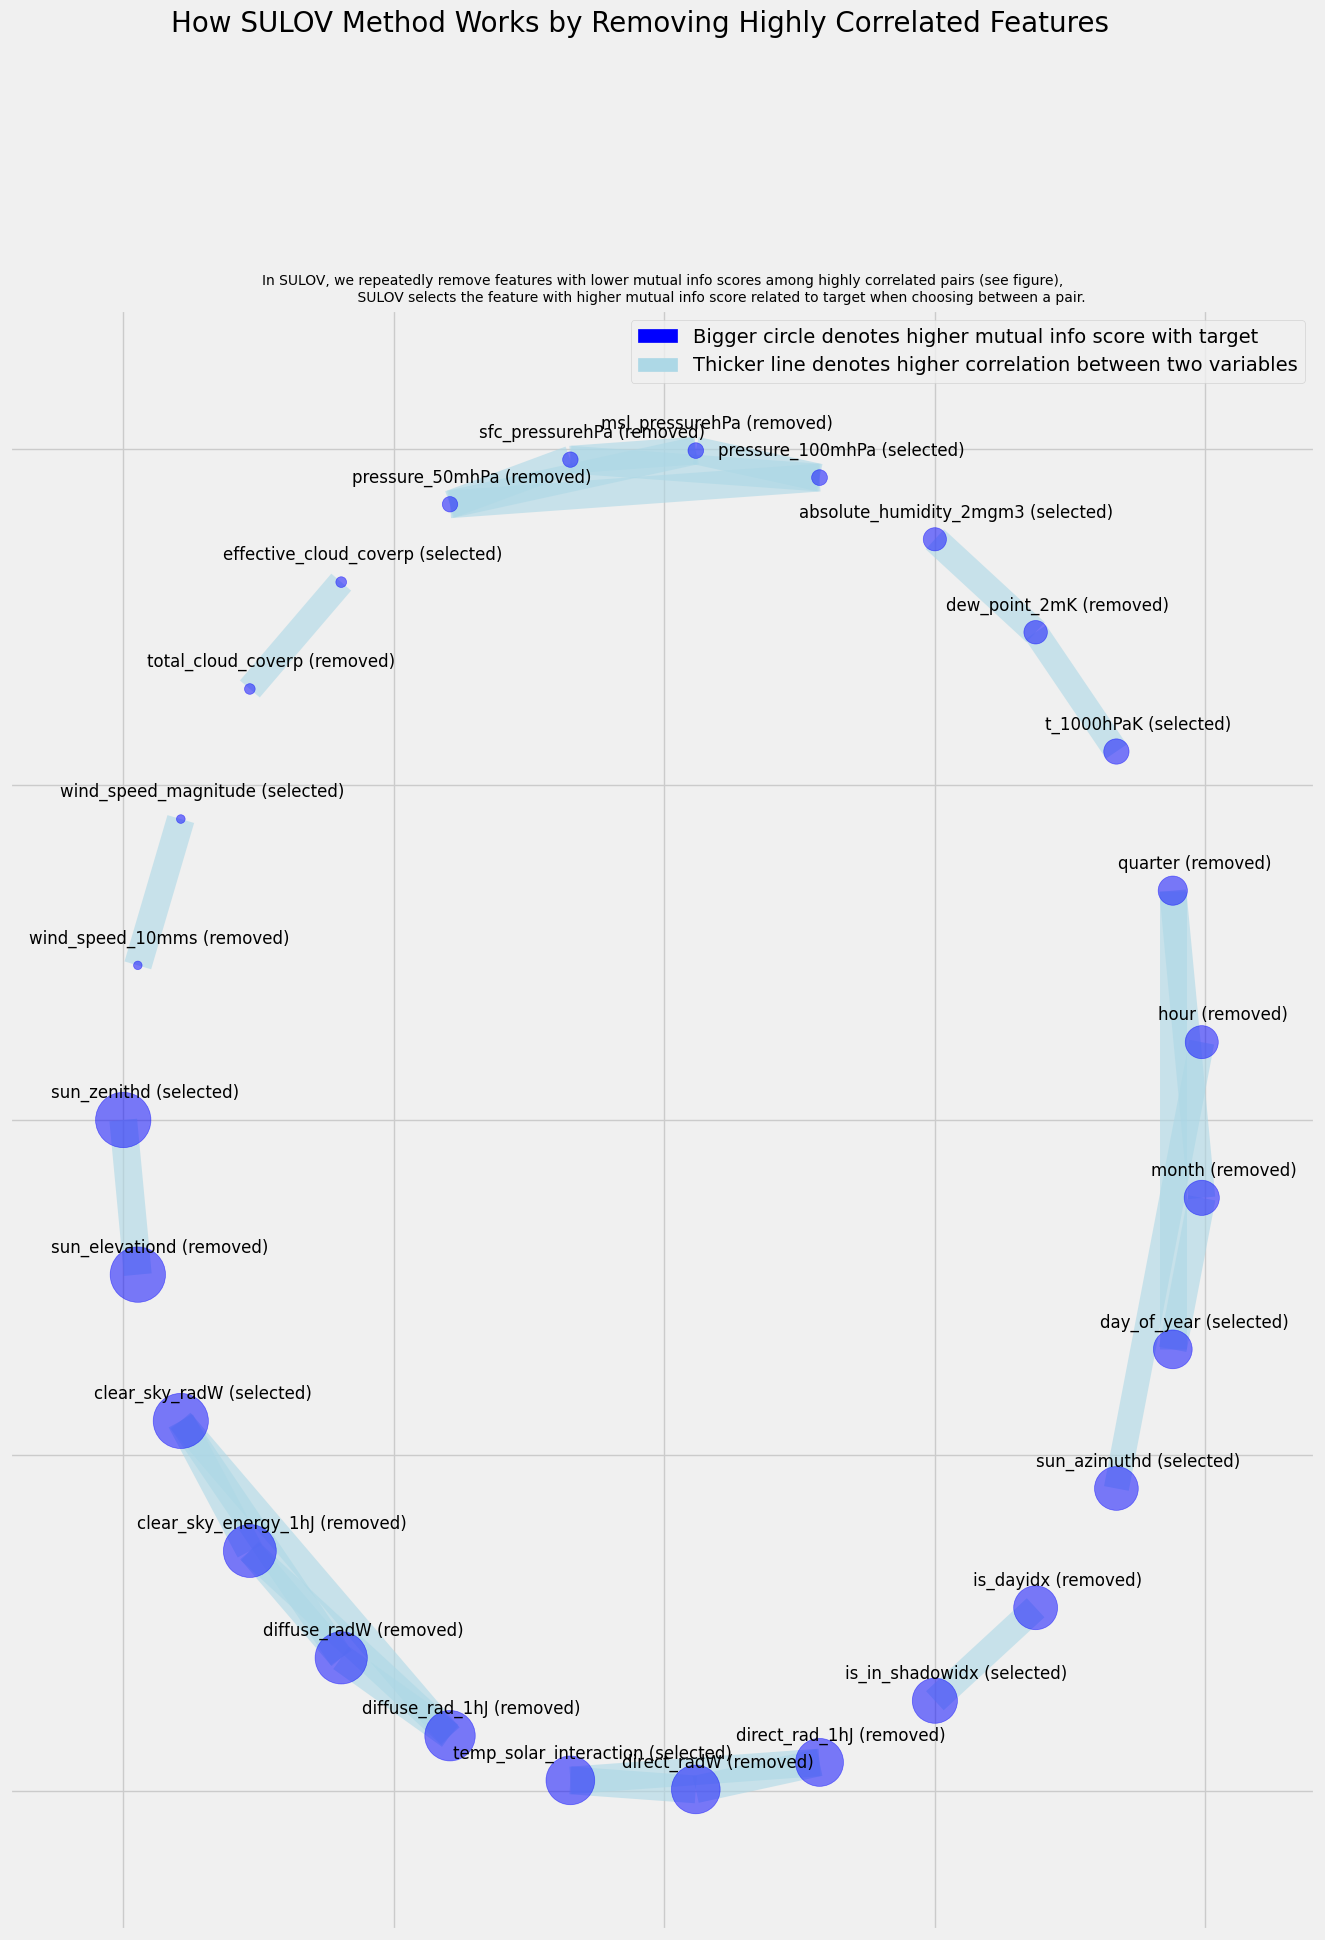

Time taken for SULOV method = 11 seconds
    Adding 0 categorical variables to reduced numeric variables  of 38
Finally 38 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 10 features per iteration...
    XGBoost version using 1.6.2 as tree method: hist
    Number of booster rounds = 100
        Selected: ['sun_zenithd', 'temp_solar_interaction', 'cumulative_precipitation', 'clear_sky_radW', 'day_of_year', 'year', 'pressure_100mhPa', 'sun_equation_of_time', 'cloud_base_aglm', 't_1000hPaK']
            Time taken for regular XGBoost feature selection = 3 seconds
        Selected: ['sun_zenithd', 'temp_solar_interaction', 'cumulative_precipitation'

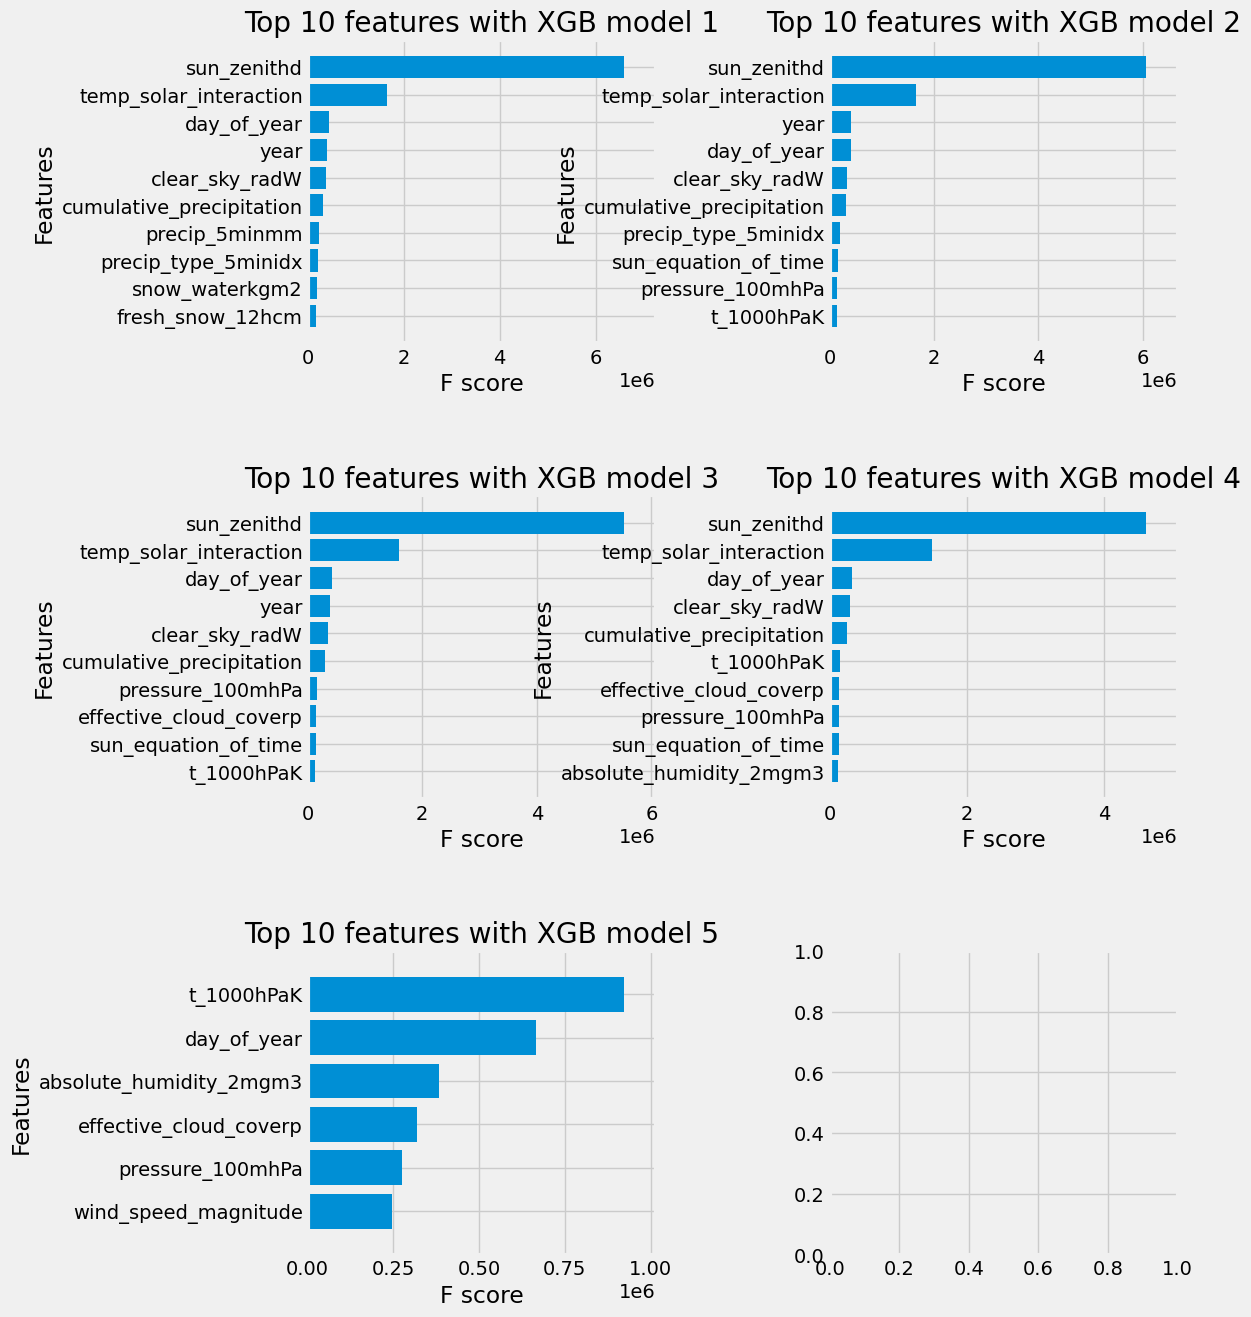

    Completed XGBoost feature selection in 4 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 14 important features:
['sun_zenithd', 'temp_solar_interaction', 'cumulative_precipitation', 'clear_sky_radW', 'day_of_year', 'year', 'pressure_100mhPa', 'sun_equation_of_time', 'cloud_base_aglm', 't_1000hPaK', 'visibilitym', 'absolute_humidity_2mgm3', 'effective_cloud_coverp', 'wind_speed_magnitude']
Total Time taken for featurewiz selection = 27 seconds
Output contains a list of 14 important features and a train dataframe
    Time taken to create entire pipeline = 27 second(s)


In [ ]:
fwiz = FeatureWiz(corr_limit=0.7, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None, verbose=2)
X_train_selected = fwiz.fit_transform(X_train, y_train)
X_test_selected = fwiz.transform(X_test)
### get list of selected features ###
feats = fwiz.features  

In [ ]:
X_train_selected.shape

(58890, 14)

In [ ]:
X_test_selected.shape

(5760, 14)

In [ ]:
X_train_selected

,sun_zenith:d,temp_solar_interaction,cumulative_precipitation,clear_sky_rad:W,day_of_year,year,pressure_100m:hPa,sun_equation_of_time,cloud_base_agl:m,t_1000hPa:K,visibility:m,absolute_humidity_2m:gm3,effective_cloud_cover:p,wind_speed_magnitude
date_forecast,,,,,,,,,,,,,,
2019-01-01 00:00:00,138.261902,0.0,2.000000e-01,0.000,1.0,2019.0,974.100,-3.203305,1200.675,278.250,16827.800,5.525,81.825,2.809021
2019-01-01 01:00:00,134.821300,0.0,2.000000e-01,0.000,1.0,2019.0,973.250,-3.223114,1131.425,278.075,12777.450,5.425,97.475,3.547774
2019-01-01 02:00:00,129.748348,0.0,2.000000e-01,0.000,1.0,2019.0,973.050,-3.242916,1061.000,278.050,11140.500,5.400,96.425,4.044272
2019-01-01 03:00:00,123.653918,0.0,2.150000e-01,0.000,1.0,2019.0,973.350,-3.262709,1021.150,277.600,6799.200,5.350,96.775,4.935922
2019-01-01 04:00:00,117.063598,0.0,2.400000e-01,0.000,1.0,2019.0,973.875,-3.282494,1033.700,277.650,5580.475,5.675,96.725,6.057831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 19:00:00,89.519936,0.0,-1.110223e-16,4.175,120.0,2023.0,999.050,2.781838,551.225,274.925,25028.000,4.400,97.725,4.061255
2023-04-30 20:00:00,94.824522,0.0,-1.110223e-16,0.000,120.0,2023.0,999.025,2.787127,564.100,274.575,23995.600,4.400,95.450,3.640372
2023-04-30 21:00:00,98.609479,0.0,-1.110223e-16,0.000,120.0,2023.0,998.900,2.792401,578.700,274.400,23068.600,4.400,93.925,3.556890


In [ ]:
X_test_selected

,sun_zenith:d,temp_solar_interaction,cumulative_precipitation,clear_sky_rad:W,day_of_year,year,pressure_100m:hPa,sun_equation_of_time,cloud_base_agl:m,t_1000hPa:K,visibility:m,absolute_humidity_2m:gm3,effective_cloud_cover:p,wind_speed_magnitude
date_forecast,,,,,,,,,,,,,,
2023-05-01 00:00:00,101.166019,0.0,NaN,0.0,121,2023,1000.6,2.806174,1039.9,273.8,31329.5,4.3,80.7,4.049691
2023-05-01 00:15:00,100.792356,0.0,NaN,0.0,121,2023,1000.5,2.807480,1053.1,273.8,31181.6,4.3,77.1,3.996248
2023-05-01 00:30:00,100.314960,0.0,NaN,0.0,121,2023,1000.4,2.808785,1066.4,273.8,31033.6,4.3,73.2,3.996248
2023-05-01 00:45:00,99.736307,0.0,NaN,0.0,121,2023,1000.2,2.810090,1079.6,273.8,30885.7,4.3,69.0,3.858756
2023-05-01 01:00:00,99.059338,0.0,NaN,0.0,121,2023,1000.1,2.811393,1092.9,273.8,30737.8,4.3,64.6,3.858756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 22:45:00,93.333591,0.0,5.551115e-17,0.0,184,2023,978.8,-4.315167,1573.0,285.3,39008.3,9.0,100.0,1.746425
2023-07-03 23:00:00,93.538016,0.0,5.551115e-17,0.0,184,2023,978.8,-4.317044,1471.0,285.2,39026.0,9.0,100.0,1.746425
2023-07-03 23:15:00,93.641724,0.0,5.551115e-17,0.0,184,2023,978.9,-4.318920,1346.9,285.1,39081.3,9.0,100.0,1.708801


In [ ]:
# # save X_train_selected and X_test_selected
# X_train_selected.to_csv(f'{save_path}X_train_selected_BC.csv')
# X_test_selected.to_csv(f'{save_path}X_test_selected_BC.csv')

In [ ]:
# save y_train
# y_train.to_csv(f'{save_path}y_train_BC.csv')